In [ ]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import re

from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import sent_tokenize, word_tokenize 

import nltk
nltk.download('punkt')
nltk.download('stopwords')

pd.set_option('max_colwidth', 400)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load Data From GitHub Repository
textData_1 = pd.read_csv('https://raw.githubusercontent.com/nruloff/Difficulty_Classification_of_Textual_Passages/main/Data/WikiLarge_Train_part_1.csv')
textData_2 = pd.read_csv('https://raw.githubusercontent.com/nruloff/Difficulty_Classification_of_Textual_Passages/main/Data/WikiLarge_Train_part_2.csv')
textData_3 = pd.read_csv('https://raw.githubusercontent.com/nruloff/Difficulty_Classification_of_Textual_Passages/main/Data/WikiLarge_Train_part_3.csv')
text_data = pd.concat([textData_1, textData_2, textData_3], ignore_index=True)

# View the top of the DataFrame of Raw Data
text_data.head()

,original_text,label
0,"There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephew , Anna and James Edward Austen , made further additions as late as 1814 .",1
1,"In a remarkable comparative analysis , Mandaean scholar Säve-Söderberg demonstrated that Mani 's Psalms of Thomas were closely related to Mandaean texts .",1
2,"Before Persephone was released to Hermes , who had been sent to retrieve her , Hades tricked her into eating pomegranate seeds , -LRB- six or three according to the telling -RRB- which forced her to return to the underworld for a period each year .",1
3,"Cogeneration plants are commonly found in district heating systems of cities , hospitals , prisons , oil refineries , paper mills , wastewater treatment plants , thermal enhanced oil recovery wells and industrial plants with large heating needs .",1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second-most-populous city in Switzerland -LRB- after Zürich -RRB- and is the most populous city of Romandie -LRB- the French-speaking part of Switzerland -RRB- .",1


In [ ]:
# Look at the total number of unique rows
text_data.nunique()

original_text    347356
label                 2
dtype: int64

In [ ]:
# Look at the total number of unique text entries
text_data.original_text.nunique()

347356

In [ ]:
# Convert binary 0 labels to -1 (this helps with keeping some of the duplicate entries)
text_data['label'] = np.where(text_data['label'] < 1, -1, 1)

# Separate out the duplicate entries from the individual entries - All duplicate entries are taken to "duplicate_texts" dataframe
duplicate_texts = text_data[text_data.original_text.duplicated(keep=False)].copy()
individual_texts = text_data[~text_data.original_text.duplicated(keep=False)].copy()

# Group the duplicate text entries by the original text and find the mean value. 
# If the mean value is negative, then most of the entries have been labeled as -1
# If the mean value is positive, then most of the entries have been labeled as 1
dup_group = duplicate_texts.groupby(['original_text'], as_index=False).mean()

# Convert all positive values to 1 and all negative values to -1
dup_group['label'] = np.where(dup_group['label'] > 0, 1, dup_group['label'])
dup_group['label'] = np.where(dup_group['label'] < 0, -1, dup_group['label'])

# However, if the label mean is 0, then it is an even split, and the text data cannot be used for classification
# Identify all rows with mean groupby label values of 0
zero_mean = dup_group[dup_group['label'] == 0]

# Identify all rows with positive groupby label values
pos_mean = dup_group[dup_group['label'] > 0].copy()
# Perform the same for all rows with negative groupby label values
neg_mean = dup_group[dup_group['label'] < 0].copy()

# Recombine the acceptable duplicate entries with the original individual entries
new_text_data = pd.concat([pos_mean, neg_mean, individual_texts], ignore_index=True)
new_text_data['label'] = np.where(new_text_data['label'] < 0, 0, 1)

In [ ]:
# Confirm that the new training data removing duplicates has the same number of unique text entries of the original text_data
print((text_data.original_text.nunique() - len(zero_mean)) == len(new_text_data))

True


In [ ]:
new_text_data.head()

,original_text,label
0,! '',1
1,"# 18475 Komi-Permyak : , Perem ; -RRB- is a city and the administrative center of Perm Krai , Russia .",1
2,"# 2 , the pseudonym of American musician Paul Gray , when performing with Slipknot",1
3,"# PAu-3-061-056 in the U.S. Copyright Records database Retrieved on June 16 , 2007 is the twenty-second episode of The Simpsons eighteenth season , airing on May 20 , 2007 as part of the one-hour season finale , alongside the episode '' 24 Minutes '' ; a repeat took place on August 19 , 2007 .",1
4,$ 3.0 billion -LRB-/O2005/O-RRB-,1


In [ ]:
# Convert binary 0 labels to -1 (this helps with keeping some of the duplicate entries)
text_data['label'] = np.where(text_data['label'] < 1, -1, 1)

# Separate out the duplicate entries from the individual entries - All duplicate entries are taken to "duplicate_texts" dataframe
duplicate_texts = text_data[text_data.original_text.duplicated(keep=False)].copy()
individual_texts = text_data[~text_data.original_text.duplicated(keep=False)].copy()

# Group the duplicate text entries by the original text and find the mean value. 
# If the mean value is negative, then most of the entries have been labeled as -1
# If the mean value is positive, then most of the entries have been labeled as 1
dup_group = duplicate_texts.groupby(['original_text'], as_index=False).mean()

In [ ]:
dup_group.head()

,original_text,label
0,!,-0.981982
1,! '',1.000000
2,# 1 -LRB- Japan -RRB-,-1.000000
3,"# 18475 Komi-Permyak : , Perem ; -RRB- is a city and the administrative center of Perm Krai , Russia .",1.000000
4,"# 2 , the pseudonym of American musician Paul Gray , when performing with Slipknot",0.500000


In [ ]:
total_entries = len(dup_group)

In [ ]:
all_non_zero = dup_group[dup_group['label'] != 0]
all_non_zero.head()

,original_text,label
0,!,-0.981982
1,! '',1.000000
2,# 1 -LRB- Japan -RRB-,-1.000000
3,"# 18475 Komi-Permyak : , Perem ; -RRB- is a city and the administrative center of Perm Krai , Russia .",1.000000
4,"# 2 , the pseudonym of American musician Paul Gray , when performing with Slipknot",0.500000


In [ ]:
all_non_zero = all_non_zero.rename(columns={'label': 'label_average'})

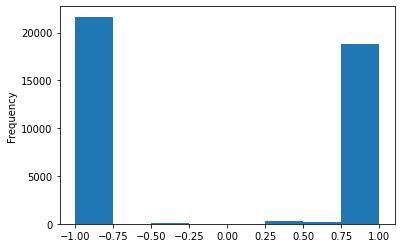

In [ ]:
ax = all_non_zero.label_average.plot.hist(bins=8, grid=False)

In [ ]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

In [ ]:
fig = ax.get_figure()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Generate the base file path name for loading the pickle file
base_path = '/content/drive/My Drive/label_average_hist.png'

fig.savefig(base_path)

Mounted at /content/drive
